<a href="https://colab.research.google.com/github/Yoshiki0418/Deep_Learning/blob/main/DL_Lecture1/nn_module.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorchのnnモジュール

In [10]:
import torch
from torch import nn
from torch.nn import functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

In [11]:
linear = nn.Linear(64, 30) # --> nn.Linear(input_dim, output_dim)
list(linear.parameters())

[Parameter containing:
 tensor([[-0.0848,  0.1023,  0.0122,  ..., -0.0013, -0.1213, -0.0543],
         [ 0.0306, -0.0220, -0.0640,  ..., -0.0692, -0.0896, -0.0756],
         [-0.0616, -0.0943, -0.0320,  ..., -0.0549,  0.1060,  0.1180],
         ...,
         [-0.1193, -0.0129, -0.0196,  ...,  0.0851,  0.0219,  0.0102],
         [ 0.0624, -0.1028, -0.0473,  ..., -0.0913, -0.0855, -0.0069],
         [-0.1108, -0.0390, -0.1168,  ...,  0.0872, -0.0018,  0.0341]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.1150,  0.0057,  0.0470, -0.0432, -0.0717, -0.0918, -0.0806,  0.0898,
          0.0638,  0.0099,  0.0184, -0.0161,  0.0643,  0.1082, -0.0071, -0.0633,
          0.1025, -0.1098,  0.0522,  0.0491, -0.0021,  0.0945, -0.0927, -0.0372,
          0.0802, -0.0106, -0.1046, -0.0022,  0.1180, -0.0133],
        requires_grad=True)]

In [12]:
print(linear.weight.shape) # weight.shape --> (output_dim, input_dim)
print(linear.bias.shape)

torch.Size([30, 64])
torch.Size([30])


In [13]:
# 順伝播
X = torch.randn((5, 64)) # --> (batch_size, data)
Z = linear(X)
Z.shape

torch.Size([5, 30])

## MLP実装

In [14]:
# 1. nn.クラスとF.関数を組み合わせたケース
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [15]:
# 順伝播
model = MLP(64, 30, 10)
X = torch.randn((5, 64))
y_pred = model(X)
y_pred.shape

torch.Size([5, 10])

In [16]:
# 2. nn.クラスのみで構成するケース
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim):
        super().__init__()
        self.l1 = nn.Linear(input_dim, hid_dim)
        self.l2 = nn.Linear(hid_dim, out_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l1(x)
        x = self.relu(x)
        x = self.l2(x)
        return x

In [17]:
# 順伝播
model = MLP(64, 30, 10)
X = torch.randn((5,64))
y_pred = model(X)
y_pred.shape

torch.Size([5, 10])

In [18]:
# 3. nn.Sequentialを使ったケース
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        x = self.block(x)
        return x

In [19]:
# 順伝播
model = MLP(64, 30, 10)
X = torch.randn((5,64))
y_pred = model(X)
y_pred.shape

torch.Size([5, 10])

In [27]:
class MLP(nn.Module):
    def __init__(self, input_dim, hid_dim, out_dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        x = self.block(x)
        return x

# ===データの準備====
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)
y_train = torch.tensor(y_train)
y_val = torch.tensor(y_val)
batch_size = 30
num_batches = np.ceil(len(y_train)/batch_size).astype(int)
model = MLP(64, 30, 10)
learning_rate = 0.03
epochs = 30

# ログ
train_losses = []
val_losses = []
val_accuracies = []

# ===学習====q
for epoch in range(epochs):
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0.0
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size

        batch_indices = shuffled_indices[start:end]
        X = X_train[batch_indices]
        y = y_train[batch_indices]

        y_pred = model(X)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        running_loss += loss.item()

        # パラメータの更新
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad
        model.zero_grad()

    # val
    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = F.cross_entropy(y_val_pred, y_val)
        val_accuracy = torch.sum(torch.argmax(y_val_pred, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch: {epoch}: train error: {running_loss/num_batches}, validation error: {val_loss.item()}, validation accuracy: {val_accuracy}')

epoch: 0: train error: 2.0777708515524864, validation error: 1.8280507326126099, validation accuracy: 0.6583333611488342
epoch: 1: train error: 1.5124255443612735, validation error: 1.2150733470916748, validation accuracy: 0.8333333134651184
epoch: 2: train error: 0.9600045879681905, validation error: 0.751134991645813, validation accuracy: 0.9111111164093018
epoch: 3: train error: 0.6335866159449021, validation error: 0.5291110873222351, validation accuracy: 0.9027777910232544
epoch: 4: train error: 0.46619797435899574, validation error: 0.3935423195362091, validation accuracy: 0.9277777671813965
epoch: 5: train error: 0.3717859474321206, validation error: 0.3239166736602783, validation accuracy: 0.9305555820465088
epoch: 6: train error: 0.31386064644902945, validation error: 0.27837425470352173, validation accuracy: 0.9333333373069763
epoch: 7: train error: 0.2696947719280918, validation error: 0.24628081917762756, validation accuracy: 0.9388889074325562
epoch: 8: train error: 0.2424

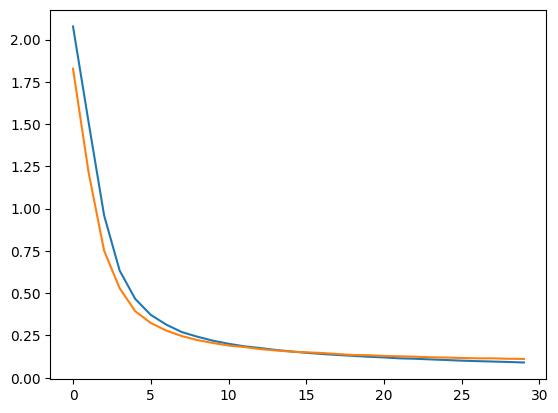

In [28]:
plt.plot(train_losses)
plt.plot(val_losses)

## パラメータのイテレーション

In [29]:
model

MLP(
  (block): Sequential(
    (0): Linear(in_features=64, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)

In [30]:
for param in model.parameters():
    print(param.shape)

torch.Size([30, 64])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


In [31]:
for name, param in model.named_parameters():
    print(name, param.shape)

block.0.weight torch.Size([30, 64])
block.0.bias torch.Size([30])
block.2.weight torch.Size([10, 30])
block.2.bias torch.Size([10])


## コンポーネントのイテレーション

In [32]:
for module in model.modules():
    print(module)

MLP(
  (block): Sequential(
    (0): Linear(in_features=64, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=10, bias=True)
  )
)
Sequential(
  (0): Linear(in_features=64, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=10, bias=True)
)
Linear(in_features=64, out_features=30, bias=True)
ReLU()
Linear(in_features=30, out_features=10, bias=True)
